# ALS Model for Movie Recommendation

The code referenced the some of the code on Spark official cite: https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.recommendation.ALS.html

In [1]:
import os
import pyspark
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DoubleType
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat, lit
from pyspark.sql.functions import udf
from pyspark.sql.types import *

In [2]:
'''ALS'''
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row

In [3]:
'''Report'''
import matplotlib.pyplot as plt
import numpy as np

In [4]:
'''Pandas'''
import pandas as pd

In [5]:
'''
global paths
'''
datasets_path = os.path.join('..','movie_recommendation_system', 'datasets')
complete_ratings_file = os.path.join(datasets_path, 'ml-latest', 'ratings.csv')
tags_file = os.path.join(datasets_path, 'ml-latest', 'tags.csv')
links_file = os.path.join(datasets_path, 'ml-latest','links.csv')
movies_file = os.path.join(datasets_path, 'ml-latest', 'movies.csv')

In [6]:
'''
load pyspark
'''
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark = SparkSession.builder.appName("Spark_Processor").config("spark.redis.port", "6379").config("spark.jars", "spark-redis-branch-2.4/target/spark-redis_2.11-2.5.0-SNAPSHOT-jar-with-dependencies.jar").getOrCreate()
conf = pyspark.SparkConf()
sc = spark.sparkContext

In [7]:
def sample_rating():
    ratingschema = StructType()\
    .add("userId", IntegerType(), True)\
    .add("movieId", IntegerType(), True)\
    .add("rating", DoubleType(), True)\
    .add("timeStamp", IntegerType(), True)
    ratingdf = spark.read.format("csv")\
    .option("header",True)\
    .schema(ratingschema)\
    .load(complete_ratings_file)
    ratingforals = ratingdf.drop("timeStamp")
    (training, test) = ratingforals.randomSplit([0.6, 0.4])
    return training, test

In [8]:
def sample_movie():
    movie = spark.read.option("inferSchema", "true")\
    .option("header", "true").csv(movies_file)
    return movie

In [9]:
class ALS_Model:
    '''
    data: rating dataframe
    '''
    def __init__(self, data):
        self.als = ALS(maxIter=3, rank = 50, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
        self.ratingforals = data.drop("timeStamp")
        self.model = self.als.fit(self.ratingforals)
        #self.prediction = self.model.transform(self.ratingforals) #without transform
    '''
    get a recommendation for a user
    
    userId: integer value for a user id
    result: recommendedMovieID: list of movie ID that a userID gets recommended
    '''
    def recommendForUser(self, userId):
        user = self.ratingforals.select("userId").distinct().filter(self.ratingforals.userId == userId)
        userSubsetRecs = self.model.recommendForUserSubset(user, 10)
        recommendations = list(userSubsetRecs.select('recommendations').toPandas()['recommendations'])
        recommendations = recommendations[0]
        recommendedMovieID = []
        for row in recommendations:
            recommendedMovieID.append(row[0])
        return recommendedMovieID
    '''
    show ALS model's prediction on given "testData"
    '''
    def predictData(self, testData):
        self.test = testData
        self.predictions = self.model.transform(testData)
        self.predictions.show()
        return self.predictions
    def recommendForMovie(self, movieId):
        movie = self.ratingforals.select("movieId").distinct().filter(self.ratingforals.movieId == movieId)
        movieSubSetRecs = self.model.recommendForItemSubset(movie, 1) #pick only one user
        return movieSubSetRecs

In [10]:
class MovieListConverter:
    def __init__(self, data):
        self.movie = data
    '''
    input: recommendedList - it convert recommendedList with only MovieID
    output: df is a dataframe which includes movie information in recommended list
    '''
    def dataFrameWithGenre(self, recommendedList):
        recommendedMovies = []
        for r in recommendedList:
            recommendedMovies.append(self.movie.filter(self.movie.movieId == r)) #append each row
        df = recommendedMovies[0]
        for r in range(1, len(recommendedMovies)):
            df = df.union(recommendedMovies[r])
        return df

In [11]:
training, test = sample_rating()
movies = sample_movie()
demo = ALS_Model(training)
mlc = MovieListConverter(movies)

In [13]:
prediction = demo.predictData(test)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|124207|    148|   3.0|  2.094536|
| 33354|    148|   3.0| 3.9921465|
| 47989|    148|   2.0| 3.0886724|
| 33138|    148|   2.5| 2.9721472|
|151614|    148|   1.0| 2.9286914|
| 38679|    148|   3.0| 3.3624716|
| 51474|    148|   4.0| 3.1495667|
| 99684|    148|   3.0| 3.0141613|
| 29943|    148|   3.0| 2.6675828|
|117168|    148|   4.0| 3.7084646|
|  3411|    148|   3.0| 2.6590517|
|  6491|    148|   4.0| 3.0579042|
|147301|    148|   3.0| 3.0709743|
|111567|    148|   3.0| 2.5394266|
| 66907|    148|   4.0| 3.4448562|
|104930|    148|   3.0| 3.4370937|
| 98520|    148|   4.0|  3.128136|
| 73827|    148|   4.0| 1.9463071|
|145182|    148|   3.0|   2.69883|
| 69123|    148|   4.5| 2.3100836|
+------+-------+------+----------+
only showing top 20 rows



In [14]:
prediction.show(100)

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|124207|    148|   3.0|  2.094536|
| 33354|    148|   3.0| 3.9921465|
| 47989|    148|   2.0| 3.0886724|
| 33138|    148|   2.5| 2.9721472|
|151614|    148|   1.0| 2.9286914|
| 38679|    148|   3.0| 3.3624716|
| 51474|    148|   4.0| 3.1495667|
| 99684|    148|   3.0| 3.0141613|
| 29943|    148|   3.0| 2.6675828|
|117168|    148|   4.0| 3.7084646|
|  3411|    148|   3.0| 2.6590517|
|  6491|    148|   4.0| 3.0579042|
|147301|    148|   3.0| 3.0709743|
|111567|    148|   3.0| 2.5394266|
| 66907|    148|   4.0| 3.4448562|
|104930|    148|   3.0| 3.4370937|
| 98520|    148|   4.0|  3.128136|
| 73827|    148|   4.0| 1.9463071|
|145182|    148|   3.0|   2.69883|
| 69123|    148|   4.5| 2.3100836|
|160836|    148|   2.0| 4.0306425|
| 49403|    148|   2.0|  1.457655|
| 98294|    148|   5.0|  4.389763|
|131314|    148|   3.5| 2.8344681|
| 25664|    148|   3.0|  2.987252|
| 64994|    148|   1

In [61]:
'''evaluate rmse from lower rank to upper rank'''
def rank_rmse(lower, upper):
    data = sample_rating()
    ratingforals = data.drop("timeStamp")
    (training, test) = ratingforals.randomSplit([0.8, 0.2])
    result = []
    for r in range(lower,upper, 10):
        als = ALS(maxIter=3, rank = r, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", 
          coldStartStrategy="drop")
        model = als.fit(training)
        predictions = model.transform(test)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")
        result.append(evaluator.evaluate(predictions))
    return result

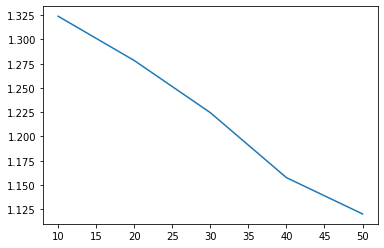

In [66]:
''' Report : test rank from 10(default) to 50 '''
rank_list = list(range(50, 9, -10))
rmse_list = rank_rmse(10, 51)
plt.plot(rank_list, rmse_list)
plt.show()

In [42]:
class Comparison:
    def __init__(self, data, movies, als, mlc):
        self.ratingJoined = data.join(movies, data.movieId ==  movies.movieId, "inner")
        self.data = data
        self.movie = movies
        self.als = als
        self.mlc = mlc
    def printRatingsofUser(self, userId):
        self.ratingJoined.filter(self.ratingJoined.userId == userId).show(truncate = False)
    def printRecommendedMovies(self, userId):
        recommendedDF = self.mlc.dataFrameWithGenre(self.als.recommendForUser(userId))
        recommendedDF.show(truncate = False)
        return recommendedDF
    def printRatingandRecommended(self, userId):
        self.printRatingsofUser(userId)
        self.printRecommendedMovies(userId)

In [43]:
cmp = Comparison(data, movies, demo, mlc)

In [44]:
titanic = demo.recommendForMovie(1721) #1721 is Titanic #previous 150441
titanic.show()

+-------+--------------------+
|movieId|     recommendations|
+-------+--------------------+
|   1721|[[156162, 6.693886]]|
+-------+--------------------+



In [45]:
cmp.printRatingandRecommended(156162)

+------+-------+------+-------+---------------------------------------------+---------------------------------------------------+
|userId|movieId|rating|movieId|title                                        |genres                                             |
+------+-------+------+-------+---------------------------------------------+---------------------------------------------------+
|156162|356    |5.0   |356    |Forrest Gump (1994)                          |Comedy|Drama|Romance|War                           |
|156162|1270   |4.0   |1270   |Back to the Future (1985)                    |Adventure|Comedy|Sci-Fi                            |
|156162|1876   |4.0   |1876   |Deep Impact (1998)                           |Drama|Sci-Fi|Thriller                              |
|156162|2080   |4.0   |2080   |Lady and the Tramp (1955)                    |Animation|Children|Comedy|Romance                  |
|156162|2571   |5.0   |2571   |Matrix, The (1999)                           |Action|Sci-Fi

In [47]:
data.filter(data.movieId == 115929).show() #1721

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
| 55101| 115929|   4.0|
|111307| 115929|   4.0|
+------+-------+------+



In [48]:
nun = demo.recommendForMovie(115929) # 134603 is "The Nun"
nun.show(truncate = False)

+-------+--------------------+
|movieId|recommendations     |
+-------+--------------------+
|115929 |[[104487, 5.383696]]|
+-------+--------------------+



In [49]:
cmp.printRatingandRecommended(104487)

+------+-------+------+-------+---------------------------------------------------------+-----------------------------------+
|userId|movieId|rating|movieId|title                                                    |genres                             |
+------+-------+------+-------+---------------------------------------------------------+-----------------------------------+
|104487|216    |3.0   |216    |Billy Madison (1995)                                     |Comedy                             |
|104487|260    |5.0   |260    |Star Wars: Episode IV - A New Hope (1977)                |Action|Adventure|Sci-Fi            |
|104487|589    |5.0   |589    |Terminator 2: Judgment Day (1991)                        |Action|Sci-Fi                      |
|104487|780    |3.0   |780    |Independence Day (a.k.a. ID4) (1996)                     |Action|Adventure|Sci-Fi|Thriller   |
|104487|2571   |5.0   |2571   |Matrix, The (1999)                                       |Action|Sci-Fi|Thriller       

In [ ]:
#115929 barbie

In [ ]:
theIronMan = demo.recommendForMovie(194228) # 194228 is "The Iron Man"
theIronMan.show()

In [ ]:
recommendation = demo.recommendForUser(1)
recommendedDF = mlc.dataFrameWithGenre(recommendation)
recommendedDF.show()

In [17]:

ratingJoined.show()

+------+-------+------+-------+--------------------+--------------------+
|userId|movieId|rating|movieId|               title|              genres|
+------+-------+------+-------+--------------------+--------------------+
|     1|    306|   3.5|    306|Three Colors: Red...|               Drama|
|     1|    307|   5.0|    307|Three Colors: Blu...|               Drama|
|     1|    665|   5.0|    665|  Underground (1995)|    Comedy|Drama|War|
|     1|   1217|   3.5|   1217|          Ran (1985)|           Drama|War|
|     1|   2351|   4.5|   2351|Nights of Cabiria...|               Drama|
|     1|   5878|   4.0|   5878|Talk to Her (Habl...|       Drama|Romance|
|     1|   6016|   5.0|   6016|City of God (Cida...|Action|Adventure|...|
|     1|   6954|   3.5|   6954|Barbarian Invasio...|Comedy|Crime|Dram...|
|     1|   7209|   4.0|   7209|M. Hulot’s Holida...|              Comedy|
|     1|   8729|   3.5|   8729|Swann in Love (Un...|               Drama|
|     1|   8973|   4.0|   8973|Bad Edu

In [108]:
userId2 = ratingJoined.filter(ratingJoined.userId == 2).show(truncate = False)

+------+-------+------+-------+------------------------------------------------------------------------------+---------------------------------------------------------+
|userId|movieId|rating|movieId|title                                                                         |genres                                                   |
+------+-------+------+-------+------------------------------------------------------------------------------+---------------------------------------------------------+
|2     |110    |5.0   |110    |Braveheart (1995)                                                             |Action|Drama|War                                         |
|2     |261    |0.5   |261    |Little Women (1994)                                                           |Drama                                                    |
|2     |333    |5.0   |333    |Tommy Boy (1995)                                                              |Comedy                                       

'\nuserID == 2 has low rating \n'

In [20]:
recommendation2 = demo.recommendForUser(2)
recommendedDF2 = mlc.dataFrameWithGenre(recommendation2)
recommendedDF2.show(truncate = False)

+-------+-------------------------------------------------+--------------------------+
|movieId|title                                            |genres                    |
+-------+-------------------------------------------------+--------------------------+
|87915  |Mondo Trasho (1969)                              |Comedy                    |
|8777   |Roadkill (a.k.a. Roadkill: Move or Die) (1989)   |Drama                     |
|51372  |"""Great Performances"" Cats (1998)"             |Musical                   |
|26225  |Claire's Knee (Genou de Claire, Le) (1970)       |Comedy|Romance            |
|93265  |Courageous (2011)                                |Drama                     |
|5825   |Life and Death of Colonel Blimp, The (1943)      |Drama|Romance|War         |
|94969  |Kahaani (2012)                                   |Crime|Drama|Thriller      |
|6093   |Last Unicorn, The (1982)                         |Animation|Children|Fantasy|
|4806   |Shop on Main Street, The (Obchod n

In [18]:
ratingJoined.filter(ratingJoined.userId == 5500).show(truncate = False)

+------+-------+------+-------+---------------------------------------------------------+------------------------------------+
|userId|movieId|rating|movieId|title                                                    |genres                              |
+------+-------+------+-------+---------------------------------------------------------+------------------------------------+
|5500  |58559  |5.0   |58559  |Dark Knight, The (2008)                                  |Action|Crime|Drama|IMAX             |
|5500  |71033  |3.0   |71033  |Secret in Their Eyes, The (El secreto de sus ojos) (2009)|Crime|Drama|Mystery|Romance|Thriller|
|5500  |87304  |3.5   |87304  |Beginners (2010)                                         |Drama                               |
|5500  |101525 |4.0   |101525 |Place Beyond the Pines, The (2012)                       |Crime|Drama                         |
|5500  |139644 |3.0   |139644 |Sicario (2015)                                           |Crime|Drama|Mystery   

In [19]:
recommendation5500 = demo.recommendForUser(5500)
recommendedDF5500 = mlc.dataFrameWithGenre(recommendation5500)
recommendedDF5500.show(truncate = False)

+-------+-------------------------------------------------------------+-----------------------+
|movieId|title                                                        |genres                 |
+-------+-------------------------------------------------------------+-----------------------+
|202231 |Foster (2018)                                                |Documentary            |
|136485 |Robot Chicken: Star Wars (2007)                              |Animation|Comedy|Sci-Fi|
|7936   |Shame (Skammen) (1968)                                       |Drama|War              |
|25748  |HE Who Gets Slapped (1924)                                   |Drama|Thriller         |
|78629  |Man There Was, A (Terje Vigen) (1917)                        |Drama                  |
|9013   |Secret Honor (1984)                                          |Drama                  |
|41126  |Clockmaker of St. Paul, The (L'horloger de Saint-Paul) (1974)|Crime|Drama            |
|198161 |Mur Murs (1981)                

In [19]:
cmp.printRatingandRecommended(4000)

+------+-------+------+-------+--------------------------------------------+------------------------------------------------+
|userId|movieId|rating|movieId|title                                       |genres                                          |
+------+-------+------+-------+--------------------------------------------+------------------------------------------------+
|4000  |296    |5.0   |296    |Pulp Fiction (1994)                         |Comedy|Crime|Drama|Thriller                     |
|4000  |5971   |5.0   |5971   |My Neighbor Totoro (Tonari no Totoro) (1988)|Animation|Children|Drama|Fantasy                |
|4000  |78499  |5.0   |78499  |Toy Story 3 (2010)                          |Adventure|Animation|Children|Comedy|Fantasy|IMAX|
|4000  |109487 |5.0   |109487 |Interstellar (2014)                         |Sci-Fi|IMAX                                     |
+------+-------+------+-------+--------------------------------------------+------------------------------------------

In [20]:
cmp.printRatingandRecommended(6000)

+------+-------+------+-------+--------------------------------------------------------------+--------------------------------------------------+
|userId|movieId|rating|movieId|title                                                         |genres                                            |
+------+-------+------+-------+--------------------------------------------------------------+--------------------------------------------------+
|6000  |11     |2.5   |11     |American President, The (1995)                                |Comedy|Drama|Romance                              |
|6000  |15     |3.0   |15     |Cutthroat Island (1995)                                       |Action|Adventure|Romance                          |
|6000  |32     |2.5   |32     |Twelve Monkeys (a.k.a. 12 Monkeys) (1995)                     |Mystery|Sci-Fi|Thriller                           |
|6000  |47     |5.0   |47     |Seven (a.k.a. Se7en) (1995)                                   |Mystery|Thriller              

In [19]:
# example of implementation
data = sample_rating()
ratingforals = data.drop("timeStamp")
(training, test) = ratingforals.randomSplit([0.5, 0.5])
als = ALS(maxIter=3, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", 
          coldStartStrategy="drop")
model = als.fit(training)
model.t
# Generate top 10 movie recommendations for each user
userRecs = model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = model.recommendForAllItems(10)
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   148|[[57946, 35.16254...|
|   463|[[47904, 19.74903...|
|   471|[[57946, 31.60759...|
|   496|[[115973, 33.9138...|
|   833|[[25789, 30.95429...|
|  1088|[[57946, 37.27958...|
|  1238|[[57946, 36.76107...|
|  1342|[[86715, 29.21999...|
|  1580|[[57946, 36.03212...|
|  1591|[[57946, 42.09615...|
|  1645|[[27884, 46.91272...|
|  1829|[[57946, 39.14211...|
|  1959|[[86715, 33.26827...|
|  2122|[[113370, 36.8535...|
|  2142|[[26073, 38.12136...|
|  2366|[[57946, 27.83738...|
|  2659|[[57946, 45.26], ...|
|  2866|[[57946, 52.85083...|
|  3175|[[115973, 31.7807...|
|  3749|[[115973, 40.5823...|
+------+--------------------+
only showing top 20 rows



In [39]:
# example of selecting userID
users1 = ratingforals.select(als.getUserCol()).distinct().filter(ratingforals.userId == 148)
users1.show()

+------+
|userId|
+------+
|   148|
+------+



In [46]:
userSubsetRecs = model.recommendForUserSubset(users1, 10)

In [54]:
recommendations = list(userSubsetRecs.select('recommendations').toPandas()['recommendations'])
recommendations = recommendations[0]

In [63]:
# example of getting recommended movies (the data format is pyspark DataFrame)
recommendations

[Row(movieId=57946, rating=35.16254806518555),
 Row(movieId=86715, rating=31.929285049438477),
 Row(movieId=115973, rating=30.611061096191406),
 Row(movieId=185659, rating=28.117338180541992),
 Row(movieId=156771, rating=26.829761505126953),
 Row(movieId=5518, rating=26.517826080322266),
 Row(movieId=84223, rating=25.6900634765625),
 Row(movieId=25759, rating=25.593900680541992),
 Row(movieId=89896, rating=25.101810455322266),
 Row(movieId=174565, rating=25.083829879760742)]